<a href="https://colab.research.google.com/github/Vinicius-A-Siqueira/CP4-IoT/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

# Configurações gerais
plt.rcParams.update({
    "figure.figsize": (10, 4),
    "axes.grid": True
})

DATA_FILE = "household_power_consumption.txt"

if not Path(DATA_FILE).exists():
    print(f"⚠️ Arquivo '{DATA_FILE}' não encontrado na pasta atual: {Path.cwd()}")
    print("Coloque o arquivo na mesma pasta do notebook e rode novamente.")
else:
    print("✅ Arquivo encontrado.")


✅ Arquivo encontrado.


In [3]:
def load_data(filepath=DATA_FILE):
    df = pd.read_csv(
        filepath,
        sep=';',
        na_values=['?', 'NA', ''],
        low_memory=False
    )
    # Conversão de tipos numéricos
    numeric_cols = [
        'Global_active_power','Global_reactive_power','Voltage',
        'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3'
    ]
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

if Path(DATA_FILE).exists():
    df = load_data()
    print("Shape:", df.shape)
    print("Colunas:", list(df.columns))

Shape: (2075259, 9)
Colunas: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [4]:
# 1- Carregue o dataset e exiba as 10 primeiras linhas.

if Path(DATA_FILE).exists():
    display(df.head(10))
else:
    print("Carregue o arquivo na pasta do notebook e rode novamente.")


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,16/12/2006,17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,16/12/2006,17:33:00,3.662,0.510,233.86,15.8,0.0,2.0,16.0


In [5]:
# 2- Diferença entre Global_active_power e Global_reactive_power

explanation = '''
- **Global_active_power**: potência **ativa** consumida (kW) — energia que realiza trabalho útil (conversão em calor, movimento, etc.).
- **Global_reactive_power**: potência **reativa** (kVAR) — energia alternada que não realiza trabalho útil diretamente; está associada a campos magnéticos/ elétricos em cargas indutivas/capacitivas e afeta a eficiência do sistema.
'''
print(explanation)


- **Global_active_power**: potência **ativa** consumida (kW) — energia que realiza trabalho útil (conversão em calor, movimento, etc.).
- **Global_reactive_power**: potência **reativa** (kVAR) — energia alternada que não realiza trabalho útil diretamente; está associada a campos magnéticos/ elétricos em cargas indutivas/capacitivas e afeta a eficiência do sistema.



In [6]:
# 3- Verifique valores ausentes e quantifique-os.

if Path(DATA_FILE).exists():
    missing_total = df.isna().sum()
    print("Valores ausentes por coluna:")
    print(missing_total)
    print("\nTotal de valores ausentes:", int(missing_total.sum()))
else:
    print("Arquivo não encontrado.")

Valores ausentes por coluna:
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Total de valores ausentes: 181853


In [9]:
# 4- Converter `Date` para datetime e criar coluna com o dia da semana.

if Path(DATA_FILE).exists():
    # Converter Date
    df['Date_dt'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
    # Dia da semana (segunda=0, domingo=6)
    df['weekday'] = df['Date_dt'].dt.day_name()  # nomes em inglês
    display(df[['Date','Date_dt','weekday']].head())
else:
    print("Arquivo não encontrado.")

,Date,Date_dt,weekday
0,16/12/2006,2006-12-16,Saturday
1,16/12/2006,2006-12-16,Saturday
2,16/12/2006,2006-12-16,Saturday
3,16/12/2006,2006-12-16,Saturday
4,16/12/2006,2006-12-16,Saturday


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date_dt']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date_dt'}, axis=1)
              .sort_values('Date_dt', ascending=True))
  xs = counted['Date_dt']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Date_dt', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date_dt')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

In [10]:
# 5- Filtrar registros de 2007 e calcular média de consumo diário de Global_active_power.

if Path(DATA_FILE).exists():
    df_2007 = df[df['Date_dt'].dt.year == 2007].copy()
    daily_mean_2007 = df_2007.groupby('Date_dt')['Global_active_power'].mean()
    print("Média de consumo diário (kW) em 2007:")
    display(daily_mean_2007.describe())
else:
    print("Arquivo não encontrado.")

Média de consumo diário (kW) em 2007:


,Global_active_power
count,364.000000
mean,1.116143
std,0.481430
min,0.222997
25%,0.756212
50%,1.051576
75%,1.403017
max,2.798418


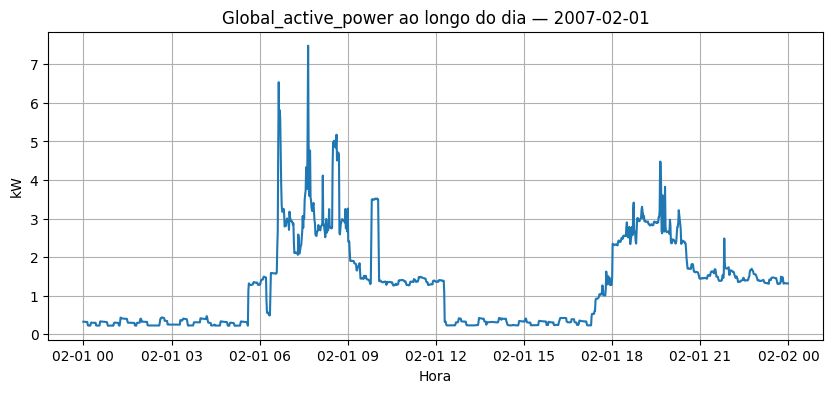

In [11]:
# 6- Gráfico de linha da variação de Global_active_power em um dia escolhido.

if Path(DATA_FILE).exists():
    # Combinar Date e Time em datetime
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    # Escolha um dia com dados (ex: 2007-02-01)
    day_choice = pd.Timestamp('2007-02-01')
    mask = (df['DateTime'].dt.date == day_choice.date())
    day_df = df.loc[mask].sort_values('DateTime')
    plt.figure()
    plt.plot(day_df['DateTime'], day_df['Global_active_power'])
    plt.title(f"Global_active_power ao longo do dia — {day_choice.date()}")
    plt.xlabel("Hora")
    plt.ylabel("kW")
    plt.show()
else:
    print("Arquivo não encontrado.")

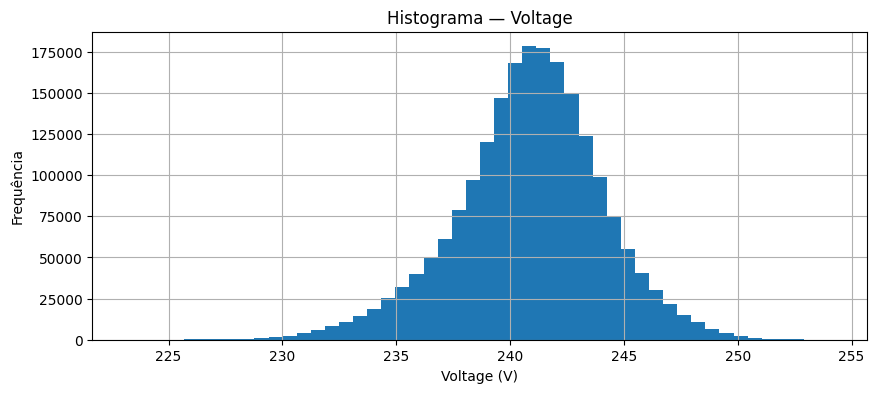

Observação: Em geral, espera-se uma distribuição aproximadamente unimodal, concentrada próximo à tensão nominal (em torno de ~240 V), com alguma dispersão.


In [12]:
# 7- Histograma de Voltage e observações sobre a distribuição.

if Path(DATA_FILE).exists():
    plt.figure()
    df['Voltage'].dropna().hist(bins=50)
    plt.title("Histograma — Voltage")
    plt.xlabel("Voltage (V)")
    plt.ylabel("Frequência")
    plt.show()

    print("Observação: Em geral, espera-se uma distribuição aproximadamente unimodal, concentrada próximo à tensão nominal (em torno de ~240 V), com alguma dispersão.")
else:
    print("Arquivo não encontrado.")

In [13]:
# 8- Consumo médio por mês em todo o período.

if Path(DATA_FILE).exists():
    df['YearMonth'] = df['Date_dt'].dt.to_period('M')
    monthly_mean = df.groupby('YearMonth')['Global_active_power'].mean().to_timestamp()
    display(monthly_mean.head())
else:
    print("Arquivo não encontrado.")

,Global_active_power
YearMonth,
2006-12-01,1.901295
2007-01-01,1.546034
2007-02-01,1.401084
2007-03-01,1.318627
2007-04-01,0.891189


In [14]:
# 9- Dia com maior consumo de energia ativa global (média diária).

if Path(DATA_FILE).exists():
    daily_mean = df.groupby('Date_dt')['Global_active_power'].mean()
    max_day = daily_mean.idxmax()
    print("Dia com maior consumo médio de Global_active_power:", max_day.date(), "—", daily_mean.max(), "kW")
else:
    print("Arquivo não encontrado.")

Dia com maior consumo médio de Global_active_power: 2006-12-23 — 3.314851388888889 kW


In [15]:
# 10- Consumo médio: dias de semana vs finais de semana.

if Path(DATA_FILE).exists():
    df['is_weekend'] = df['Date_dt'].dt.weekday >= 5
    daily = df.groupby(['Date_dt','is_weekend'])['Global_active_power'].mean().reset_index()
    weekday_mean = daily.loc[~daily['is_weekend'],'Global_active_power'].mean()
    weekend_mean = daily.loc[daily['is_weekend'],'Global_active_power'].mean()
    print(f"Média (dias de semana): {weekday_mean:.4f} kW")
    print(f"Média (finais de semana): {weekend_mean:.4f} kW")
else:
    print("Arquivo não encontrado.")


Média (dias de semana): 1.0367 kW
Média (finais de semana): 1.2311 kW


In [16]:
# 11- Correlação entre GA, GR, Voltage e GI.

if Path(DATA_FILE).exists():
    corr_cols = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity']
    corr = df[corr_cols].corr()
    display(corr)
else:
    print("Arquivo não encontrado.")

,Global_active_power,Global_reactive_power,Voltage,Global_intensity
Global_active_power,1.000000,0.247017,-0.399762,0.998889
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120
Voltage,-0.399762,-0.112246,1.000000,-0.411363
Global_intensity,0.998889,0.266120,-0.411363,1.000000


In [17]:
# 12- Nova variável Total_Sub_metering.

if Path(DATA_FILE).exists():
    df['Total_Sub_metering'] = df[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].sum(axis=1, skipna=True)
    display(df[['Sub_metering_1','Sub_metering_2','Sub_metering_3','Total_Sub_metering']].head())
else:
    print("Arquivo não encontrado.")

,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_Sub_metering
0,0.0,1.0,17.0,18.0
1,0.0,1.0,16.0,17.0
2,0.0,2.0,17.0,19.0
3,0.0,1.0,17.0,18.0
4,0.0,1.0,17.0,18.0


In [18]:
# 13- Verificar mês em que Total_Sub_metering ultrapassa a média de Global_active_power.

if Path(DATA_FILE).exists():
    monthly = df.groupby('YearMonth').agg({
        'Total_Sub_metering':'mean',
        'Global_active_power':'mean'
    })
    cond = monthly['Total_Sub_metering'] > monthly['Global_active_power']
    result = monthly[cond]
    print("Meses onde a média de Total_Sub_metering > média de Global_active_power:")
    display(result)
else:
    print("Arquivo não encontrado.")

Meses onde a média de Total_Sub_metering > média de Global_active_power:


,Total_Sub_metering,Global_active_power
YearMonth,,
2006-12,10.871204,1.901295
2007-01,10.423051,1.546034
2007-02,9.485665,1.401084
2007-03,10.212634,1.318627
2007-04,6.249954,0.891189
2007-05,8.452442,0.985862
2007-06,7.371806,0.826814
2007-07,5.681004,0.667367
2007-08,6.975896,0.764186


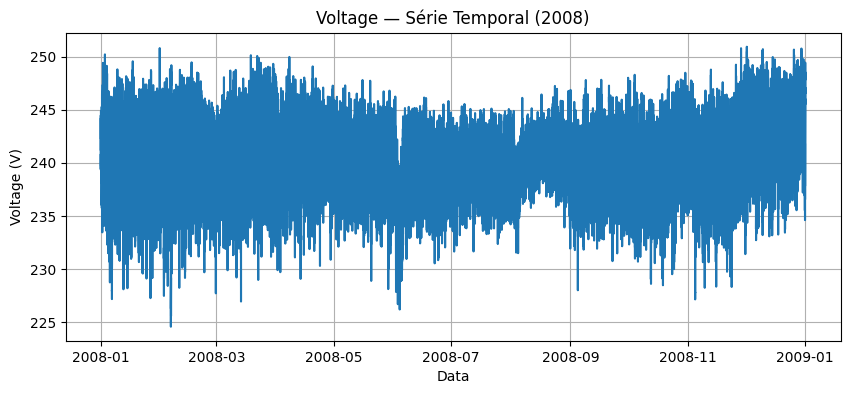

In [19]:
# 14- Série temporal de Voltage para 2008.

if Path(DATA_FILE).exists():
    mask_2008 = df['Date_dt'].dt.year == 2008
    df_2008 = df.loc[mask_2008].copy()
    df_2008 = df_2008.sort_values('DateTime')
    plt.figure()
    plt.plot(df_2008['DateTime'], df_2008['Voltage'])
    plt.title("Voltage — Série Temporal (2008)")
    plt.xlabel("Data")
    plt.ylabel("Voltage (V)")
    plt.show()
else:
    print("Arquivo não encontrado.")

In [20]:
# 15- Comparar consumo entre meses de verão e inverno (Hemisfério Norte).

if Path(DATA_FILE).exists():
    # Verão (HN): Jun, Jul, Ago; Inverno (HN): Dez, Jan, Fev
    df['month'] = df['Date_dt'].dt.month
    summer_months = [6,7,8]
    winter_months = [12,1,2]
    summer = df[df['month'].isin(summer_months)].groupby('Date_dt')['Global_active_power'].mean().mean()
    winter = df[df['month'].isin(winter_months)].groupby('Date_dt')['Global_active_power'].mean().mean()
    print(f"Média verão (HN): {summer:.4f} kW")
    print(f"Média inverno (HN): {winter:.4f} kW")
else:
    print("Arquivo não encontrado.")

Média verão (HN): 0.7264 kW
Média inverno (HN): 1.4226 kW


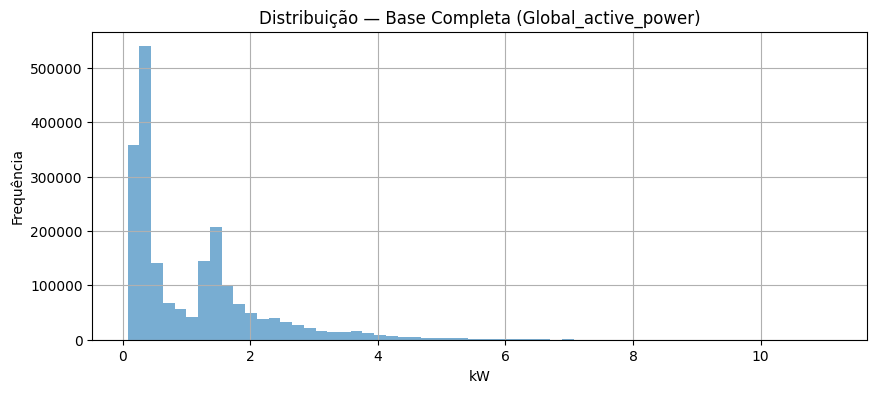

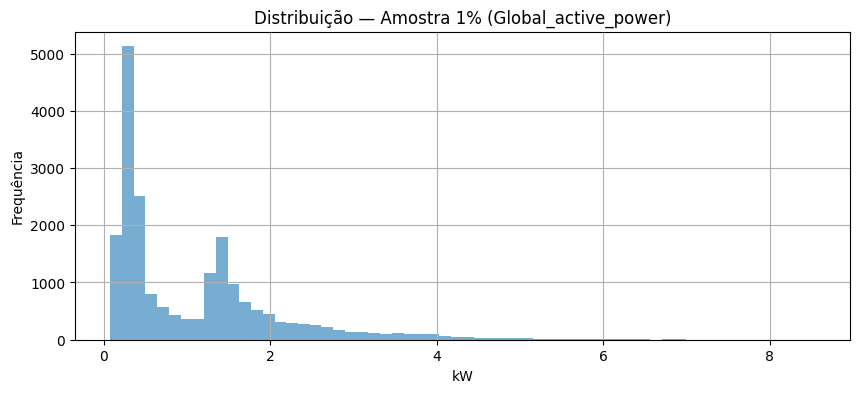

Compare visualmente as distribuições para similaridade geral de formato/caudas.


In [21]:
# 16- Amostragem aleatória de 1% e comparação da distribuição de Global_active_power.

if Path(DATA_FILE).exists():
    full = df['Global_active_power'].dropna()
    sample = full.sample(frac=0.01, random_state=42)
    plt.figure()
    full.hist(bins=60, alpha=0.6)
    plt.title("Distribuição — Base Completa (Global_active_power)")
    plt.xlabel("kW")
    plt.ylabel("Frequência")
    plt.show()

    plt.figure()
    sample.hist(bins=60, alpha=0.6)
    plt.title("Distribuição — Amostra 1% (Global_active_power)")
    plt.xlabel("kW")
    plt.ylabel("Frequência")
    plt.show()

    print("Compare visualmente as distribuições para similaridade geral de formato/caudas.")
else:
    print("Arquivo não encontrado.")

In [22]:
# 17- Normalização (Min-Max Scaling) das variáveis numéricas principais.

if Path(DATA_FILE).exists():
    num_cols = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity',
                'Sub_metering_1','Sub_metering_2','Sub_metering_3','Total_Sub_metering']
    data_num = df[num_cols].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data_num)
    scaled_df = pd.DataFrame(scaled, columns=num_cols, index=data_num.index)
    display(scaled_df.head())
else:
    print("Arquivo não encontrado.")

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_Sub_metering
0,0.374796,0.300719,0.376090,0.377593,0.0,0.0125,0.548387,0.134328
1,0.478363,0.313669,0.336995,0.473029,0.0,0.0125,0.516129,0.126866
2,0.479631,0.358273,0.326010,0.473029,0.0,0.0250,0.548387,0.141791
3,0.480898,0.361151,0.340549,0.473029,0.0,0.0125,0.548387,0.134328
4,0.325005,0.379856,0.403231,0.323651,0.0,0.0125,0.548387,0.134328


In [23]:
# 18- K-means para segmentar dias (3 clusters) e interpretação.

if Path(DATA_FILE).exists():
    # Featurização diária
    feats = df.groupby('Date_dt').agg({
        'Global_active_power':'mean',
        'Global_reactive_power':'mean',
        'Voltage':'mean',
        'Global_intensity':'mean',
        'Total_Sub_metering':'mean'
    }).dropna()

    scaler_days = MinMaxScaler()
    X = scaler_days.fit_transform(feats)

    km = KMeans(n_clusters=3, random_state=42, n_init=10)
    feats['cluster'] = km.fit_predict(X)

    print("Tamanho dos clusters:")
    print(feats['cluster'].value_counts().sort_index())

    print("\nMédias por cluster:")
    display(feats.groupby('cluster').mean())

    # Interpretação (texto)
    print("\nInterpretação geral: clusters com maior média de Global_active_power/Total_Sub_metering tendem a representar dias de maior consumo; tensões/reativa podem distinguir perfis elétricos distintos.")
else:
    print("Arquivo não encontrado.")


Tamanho dos clusters:
cluster
0    689
1    281
2    463
Name: count, dtype: int64

Médias por cluster:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Total_Sub_metering
cluster,,,,,
0,1.148010,0.110268,241.198653,4.839933,9.179988
1,1.658981,0.142705,241.003222,6.992332,14.012503
2,0.664693,0.132512,240.196144,2.883025,5.149580



Interpretação geral: clusters com maior média de Global_active_power/Total_Sub_metering tendem a representar dias de maior consumo; tensões/reativa podem distinguir perfis elétricos distintos.


/tmp/ipython-input-2616554800.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_hourly = df.set_index('DateTime')['Global_active_power'].resample('1H').mean().dropna()


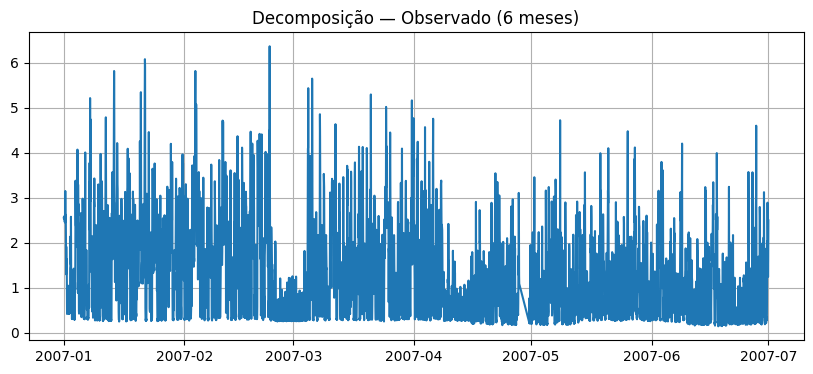

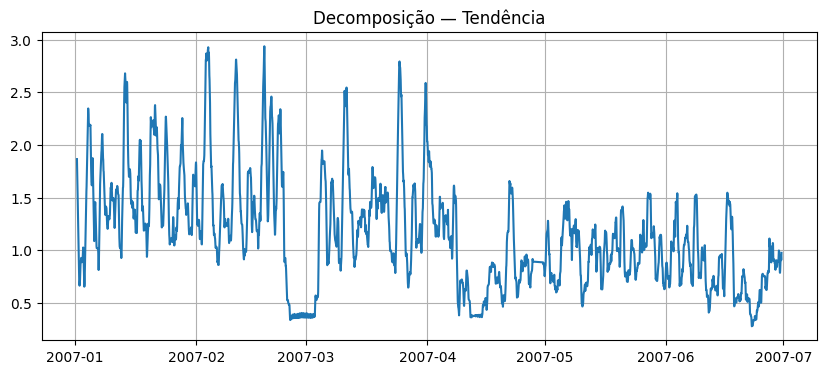

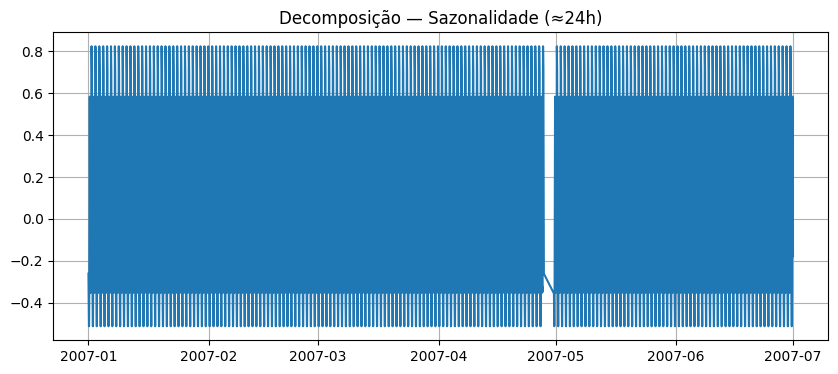

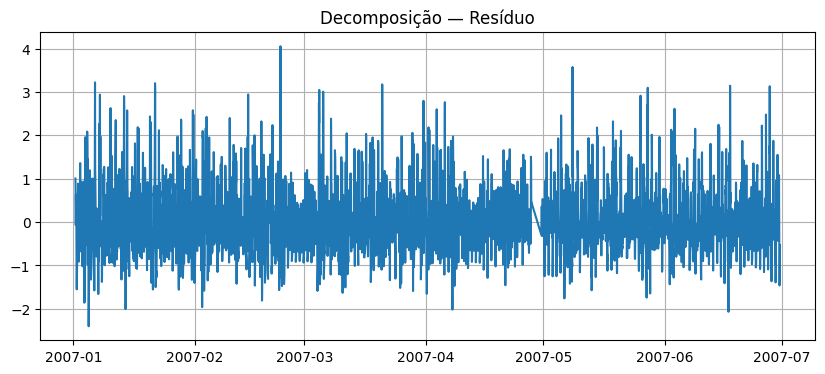

In [24]:
# 19- Decomposição de série temporal (6 meses) para Global_active_power.

if Path(DATA_FILE).exists():
    # Série por hora para 6 meses iniciando em 2007-01 (ajuste se desejar)
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    ts_hourly = df.set_index('DateTime')['Global_active_power'].resample('1H').mean().dropna()

    # Seleciona janela de 6 meses
    start = pd.Timestamp('2007-01-01')
    end = start + pd.DateOffset(months=6)
    ts_6m = ts_hourly.loc[start:end].dropna()

    result = seasonal_decompose(ts_6m, model='additive', period=24)  # sazonalidade diária (24h)
    # Plot manual em figuras separadas para cumprir a regra (1 por figura)
    plt.figure()
    plt.plot(result.observed.index, result.observed.values)
    plt.title("Decomposição — Observado (6 meses)")
    plt.show()

    plt.figure()
    plt.plot(result.trend.index, result.trend.values)
    plt.title("Decomposição — Tendência")
    plt.show()

    plt.figure()
    plt.plot(result.seasonal.index, result.seasonal.values)
    plt.title("Decomposição — Sazonalidade (≈24h)")
    plt.show()

    plt.figure()
    plt.plot(result.resid.index, result.resid.values)
    plt.title("Decomposição — Resíduo")
    plt.show()
else:
    print("Arquivo não encontrado.")